# Lab 7: Crime and Penalty

Welcome to Lab 7!

In [75]:
# Run this cell to set up the notebook, but please don't change it.

# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

## 1. A/B Testing

A/B testing is a form of hypothesis testing that allows you to make comparisons between two distributions.

You'll almost never be explicitly asked to perform an A/B test. Make sure you can identify situations where the test is appropriate and know how to correctly implement each step.  

**Question 1.1:** The following statements are the unordered steps of an A/B hypothesis test:

1. Find the value of the observed test statistic

2. Choose a test statistic (typically the difference in means between two categories)

3. Shuffle the labels of the original sample, find your simulated test statistic, and repeat many times

4. Calculate the p-value based off your observed and simulated test statistics

5. Define a null and alternate model

6. Use the p-value and p-value cutoff to draw a conclusion about the null hypothesis

Make an array called `ab_test_order` that contains the correct order of an A/B test, where the first item of the array is the first step of an A/B test and the last item of the array is the last step of an A/B test

<!--
BEGIN QUESTION
name: q1_1
-->

In [76]:
ab_test_order = [5, 2, 1, 3, 4, 6]

**Question 1.2:** If the null hypothesis of an A/B test is correct, should the order of labels affect the differences in means between each group? Why do we shuffle labels in an A/B test? 

<!--
BEGIN QUESTION
name: q1_2
-->

If the null hypothesis of an A/B test is correct, the order of labels should not affect the differences in means between each group. The purpose of shuffling labels in the test is to break any association between the two groups, and to examine what would happen if there were no effect of the treatment.

## 2: Murder Rates

Punishment for crime has many [philosophical justifications](https://plato.stanford.edu/entries/legal-punishment/).  An important one is that fear of punishment may *deter* people from committing crimes.

In the United States, some jurisdictions execute people who are convicted of particularly serious crimes, such as murder.  This punishment is called the *death penalty* or *capital punishment*.  The death penalty is controversial, and deterrence has been one focal point of the debate.  There are other reasons to support or oppose the death penalty, but in this project we'll focus on deterrence.

The key question about deterrence is:

> Through our exploration, does instituting a death penalty for murder actually reduce the number of murders?

You might have a strong intuition in one direction, but the evidence turns out to be surprisingly complex.  Different sides have variously argued that the death penalty has no deterrent effect and that each execution prevents 8 murders, all using statistical arguments!  We'll try to come to our own conclusion.

#### The data

The main data source for this lab comes from a [paper](http://cjlf.org/deathpenalty/DezRubShepDeterFinal.pdf) by three researchers, Dezhbakhsh, Rubin, and Shepherd.  The dataset contains rates of various violent crimes for every year 1960-2003 (44 years) in every US state.  The researchers compiled the data from the FBI's Uniform Crime Reports.

Since crimes are committed by people, not states, we need to account for the number of people in each state when we're looking at state-level data.  Murder rates are calculated as follows:

$$\text{murder rate for state X in year Y} = \frac{\text{number of murders in state X in year Y}}{\text{population in state X in year Y}}*100000$$

(Murder is rare, so we multiply by 100,000 just to avoid dealing with tiny numbers.)

In [77]:
murder_rates = Table.read_table('crime_rates.csv').select('State', 'Year', 'Population', 'Murder Rate')
murder_rates.set_format("Population", NumberFormatter)

State,Year,Population,Murder Rate
Alaska,1960,"226,167",10.2
Alaska,1961,"234,000",11.5
Alaska,1962,"246,000",4.5
Alaska,1963,"248,000",6.5
Alaska,1964,"250,000",10.4
Alaska,1965,"253,000",6.3
Alaska,1966,"272,000",12.9
Alaska,1967,"272,000",9.6
Alaska,1968,"277,000",10.5
Alaska,1969,"282,000",10.6


Murder rates vary over time, and different states exhibit different trends. The rates in some states change dramatically from year to year, while others are quite stable. Let's plot a couple, just to see the variety.

**Question 2.1.** Draw a line plot with years on the horizontal axis and murder rates on the vertical axis. Include two lines: one for North Carolina murder rates and one for Texas murder rates. Create this plot using a single call, `nc_tx.plot('Year')`.

*Hint*: To create two lines, you will need create the table `nc_tx` with two columns of murder rates, in addition to a column of years. This table will have the following structure:

| Year | Murder rate in North Carolina | Murder rate in Texas     |
|------|-------------------------------|--------------------------|
| 1960 | 10.6                          | 8.6                      |
| 1961 | 9.2                           | 8.1                      |
| 1962 | 7.9                           | 7.2                      |

<center>... (41 rows omitted)</center>

<!--
BEGIN QUESTION
name: q2_1
-->

In [78]:
# The next lines are provided for you. They create a table
# containing only the North Carolina information and one containing
# only the Texas information.

nc = murder_rates.where('State', 'North Carolina').drop('State', 'Population').relabeled(1, 'Murder rate in North Carolina')
tx = murder_rates.where('State', 'Texas').drop('State', 'Population').relabeled(1, 'Murder rate in Texas')

# Fill in this line to make a table like the one pictured above.
nc_tx = nc.with_column("Murder rate in Texas", tx.column(1))
nc_tx

Year,Murder rate in North Carolina,Murder rate in Texas
1960,10.6,8.6
1961,9.2,8.1
1962,7.9,7.2
1963,8.2,7.4
1964,8,7.6
1965,8.3,7.5
1966,9.2,9.1
1967,9.9,9.9
1968,10.2,10.6
1969,11.3,11.3


**Question 2.2:** Using the table `nc_tx`, draw a line plot that compares the murder rate in North Carolina and the murder rate in Texas over time.

<!--
BEGIN QUESTION
name: q2_2
-->

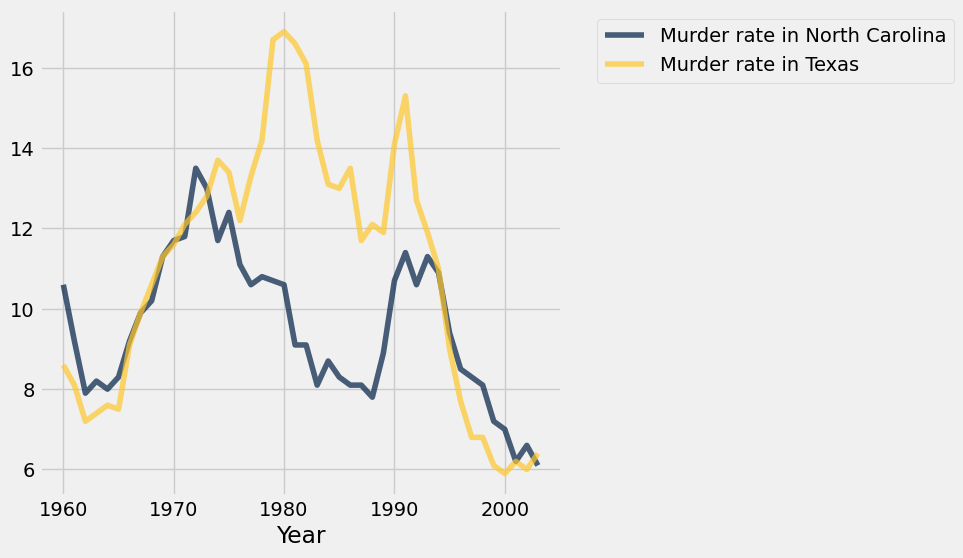

In [79]:
# Draw your line plot here
nc_tx.plot("Year")

## 3. The Death Penalty

Some US states have the death penalty, and others don't, and laws have changed over time. In addition to changes in murder rates, we will also consider whether the death penalty was in force in each state and each year.

Using this information, we would like to investigate how the presence of the death penalty affects the murder rate of a state.

**Question 3.1.** We want to know whether the death penalty *causes* a change in the murder rate.  Why is it not sufficient to compare murder rates in places and times when the death penalty was in force with places and times when it wasn't?

<!--
BEGIN QUESTION
name: q3_1
-->

We can't conclude a causal relationship between two variables just based on observation. We need experiment.

### A Natural Experiment

In order to attempt to investigate the causal relationship between the death penalty and murder rates, we're going to take advantage of a *natural experiment*.  A natural experiment happens when something other than experimental design applies a treatment to one group and not to another (control) group, and we have some hope that the treatment and control groups don't have any other systematic differences.

Our natural experiment is this: in 1972, a Supreme Court decision called *Furman v. Georgia* banned the death penalty throughout the US.  Suddenly, many states went from having the death penalty to not having the death penalty.

As a first step, let's see how murder rates changed before and after the court decision.  We'll define the test as follows:

> **Population:** All the states that had the death penalty before the 1972 abolition.  (There is no control group for the states that already lacked the death penalty in 1972, so we must omit them.)  This includes all US states **except** Alaska, Hawaii, Maine, Michigan, Wisconsin, and Minnesota.

> **Treatment group:** The states in that population, in 1973 (the year after 1972).

> **Control group:** The states in that population, in 1971 (the year before 1972).

> **Null hypothesis:** Murder rates in 1971 and 1973 come from the same distribution.

> **Alternative hypothesis:** Murder rates were higher in 1973 than they were in 1971.

Our alternative hypothesis is related to our suspicion that murder rates increase when the death penalty is eliminated.  

**Question 3.2:** Should we use an A/B test to test these hypotheses? If yes, what is our "A" group and what is our "B" group?

<!--
BEGIN QUESTION
name: q3_2
-->

Yes. The "A" group should be the Treatment group, and the "B" group should be the Control group. Both group should exclude the exceptions mentioned: Alaska, Hawaii, Maine, Michigan, Wisconsin, and Minnesota

The `death_penalty` table below describes whether each state allowed the death penalty in 1971.

In [80]:
non_death_penalty_states = make_array('Alaska', 'Hawaii', 'Maine', 'Michigan', 'Wisconsin', 'Minnesota')

def had_death_penalty_in_1971(state):
    """Returns True if the argument is the name of a state that had the death penalty in 1971."""
    # The implementation of this function uses a bit of syntax
    # we haven't seen before.  Just trust that it behaves as its
    # documentation claims.
    return state not in non_death_penalty_states

states = murder_rates.group('State').select('State')
death_penalty = states.with_column('Death Penalty', states.apply(had_death_penalty_in_1971, 0))
death_penalty

State,Death Penalty
Alabama,True
Alaska,False
Arizona,True
Arkansas,True
California,True
Colorado,True
Connecticut,True
Delaware,True
Florida,True
Georgia,True


**Question 3.3:** Use the `death_penalty` and `murder_rates` tables to find murder rates in 1971 for states with the death penalty before the abolition. Create a new table `preban_rates` that contains the same information as `murder_rates`, along with a column `Death Penalty` that contains booleans (`True` or `False`) describing if states had the death penalty in 1971. This table should only include those states with the death penalty in 1971.

<!--
BEGIN QUESTION
name: q3_3
-->

In [81]:
# States that had death penalty in 1971
preban_rates = murder_rates.join("State", death_penalty).where("Year", are.equal_to(1971)).where("Death Penalty", are.equal_to(True))
preban_rates

State,Year,Population,Murder Rate,Death Penalty
Alabama,1971,"3,479,000",15.1,True
Arizona,1971,"1,849,000",6.7,True
Arkansas,1971,"1,944,000",10.5,True
California,1971,"20,223,000",8.1,True
Colorado,1971,"2,283,000",6.5,True
Connecticut,1971,"3,081,000",3.1,True
Delaware,1971,"558,000",6.1,True
Florida,1971,"7,041,000",13.3,True
Georgia,1971,"4,664,000",16,True
Idaho,1971,"732,000",3.3,True


**Question 3.4:** Create a table `postban_rates` that contains the same information as `preban_rates`, but for 1973 instead of 1971. `postban_rates` should only contain the states found in `preban_rates` and all states should show that they do not have the death penalty.

<!--
BEGIN QUESTION
name: q3_4
-->

In [82]:
postban_rates = murder_rates.join("State", death_penalty).where("Year", are.equal_to(1973)).where("Death Penalty", are.equal_to(True)).drop("Death Penalty").with_column("Death Penalty", np.repeat(False, 44))
postban_rates = postban_rates.sort("State")
postban_rates

State,Year,Population,Murder Rate,Death Penalty
Alabama,1973,"3,539,000",13.2,False
Arizona,1973,"2,058,000",8.1,False
Arkansas,1973,"2,037,000",8.8,False
California,1973,"20,601,000",9,False
Colorado,1973,"2,437,000",7.9,False
Connecticut,1973,"3,076,000",3.3,False
Delaware,1973,"576,000",5.9,False
Florida,1973,"7,678,000",15.4,False
Georgia,1973,"4,786,000",17.4,False
Idaho,1973,"770,000",2.6,False


**Question 3.5:** Use `preban_rates_copy` and `postban_rates` to create a table `change_in_death_rates` that contains each state's population, murder rate, and whether or not that state had the death penalty for both 1971 and 1973. The table should contain two rows for each state and have the same column labels as `preban_rates`.

*Hint:* `tbl_1.append(tbl_2)` will create a new table that includes rows from both `tbl_1` and `tbl_2`. Both tables must have the exactly the same columns, in the same order.

<!--
BEGIN QUESTION
name: q3_5
-->

In [83]:
preban_rates_copy = preban_rates.copy()
change_in_death_rates = postban_rates.append(preban_rates_copy)
change_in_death_rates

State,Year,Population,Murder Rate,Death Penalty
Alabama,1973,"3,539,000",13.2,False
Arizona,1973,"2,058,000",8.1,False
Arkansas,1973,"2,037,000",8.8,False
California,1973,"20,601,000",9,False
Colorado,1973,"2,437,000",7.9,False
Connecticut,1973,"3,076,000",3.3,False
Delaware,1973,"576,000",5.9,False
Florida,1973,"7,678,000",15.4,False
Georgia,1973,"4,786,000",17.4,False
Idaho,1973,"770,000",2.6,False


Run the cell below to view the distribution of death rates during the pre-ban and post-ban time periods.

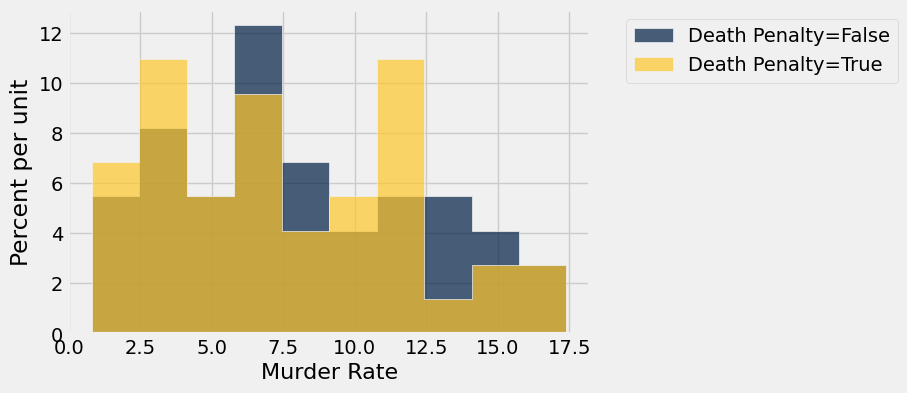

In [92]:
change_in_death_rates.hist('Murder Rate', group = 'Death Penalty')

**Question 3.6:** Create a table `rate_means` that contains the average murder rates for the states that had the death penalty and the states that didn't have the death penalty. It should have two columns: one indicating if the penalty was in place, and one that contains the average murder rate for each group.

<!--
BEGIN QUESTION
name: q3_6
-->

In [85]:
rate_means = change_in_death_rates.select("Death Penalty", "Murder Rate").group("Death Penalty", collect= np.average)
rate_means

Death Penalty,Murder Rate average
False,8.12045
True,7.51364


**Question 3.7:** We want to figure out if there is a difference between the distribution of death rates in 1971 and 1973. Specifically, we want to test if murder rates were higher in 1973 than they were in 1971. 

What should the test statistic be? How does it help us differentiate whether the data supports the null and alternative? 

<!--
BEGIN QUESTION
name: q3_7
-->

We want to calculate the absolute difference between two averages. This indicates whether or not the data supports the null hypothesis. As if the difference is small, it indicates the fact that the death rates are not linked to the abolishment of death penalty, vice versa. 

**Question 3.8:** Set `observed_difference` to the observed test statistic using the `rate_means` table 

<!--
BEGIN QUESTION
name: q3_8
-->

In [93]:
observed_difference = abs(rate_means.column(1).item(0) - rate_means.column(1).item(1))
observed_difference

0.6068181600659095

**Question 3.9:** Given a table like `change_in_death_rates`, a value column `label`, and a group column `group_label`, write a function that calculates the appropriate test statistic.

<!--
BEGIN QUESTION
name: q3_9
-->

In [87]:
def find_test_stat(table, labels_col, values_col):
    "Calculate the observed difference between averages."
    A = table.select(labels_col, values_col).group(labels_col, np.average).column(1).item(0)
    B = table.select(labels_col, values_col).group(labels_col, np.average).column(1).item(1)
    return abs(A - B)

find_test_stat(change_in_death_rates, "Death Penalty", "Murder Rate")

0.6068181600659095

When we run a simulation for A/B testing, we resample by shuffling the labels of the original sample. If the null hypothesis is true and the murder rate distributions are the same, we expect that the difference in mean death rates will be not change when "Death Penalty" labels are changed.

**Question 3.10:** Write a function `simulate_and_test_statistic` to compute one trial of our A/B test. Your function should run a simulation and return a test statistic.

<!--
BEGIN QUESTION
name: q3_10
-->

In [88]:
def simulate_and_test_statistic(table, labels_col, values_col):
    shuffled_labels = table.sample(with_replacement = False).column(labels_col)
    shuffled_table = table.select(values_col).with_column('Shuffled Label', shuffled_labels)
    
    return find_test_stat(shuffled_table, "Shuffled Label", values_col)

simulate_and_test_statistic(change_in_death_rates, "Death Penalty", "Murder Rate")

0.34318175511136495

**Question 3.11:** Simulate 5000 trials of our A/B test and store the test statistics in an array called `differences`

<!--
BEGIN QUESTION
name: q3_11
-->

In [89]:
# This cell might take a couple seconds to run
differences = make_array()
for i in np.arange(5000):
    new_difference = simulate_and_test_statistic(change_in_death_rates, "Death Penalty", "Murder Rate")
    differences = np.append(differences, new_difference)                  
differences

array([ 0.49772726,  1.05681816,  2.16136353, ...,  1.41136358,
        0.65681817,  0.0931818 ])

Run the cell below to view a histogram of your simulated test statistics plotted with your observed test statistic

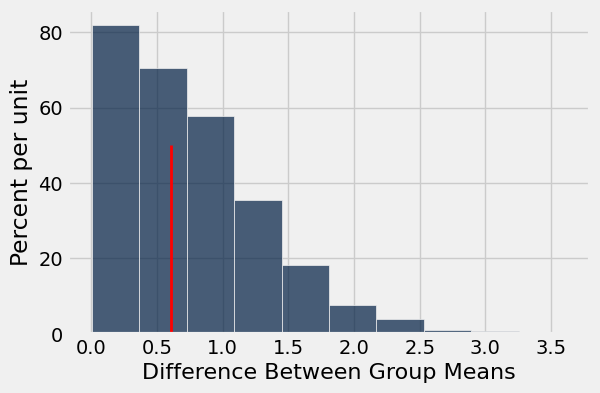

In [90]:
Table().with_column('Difference Between Group Means', differences).hist()
plt.plot([observed_difference, observed_difference], [0, 0.5], color='red', lw=2);

**Question 3.12:** Find the p-value for your test and assign it to `empirical_P`

<!--
BEGIN QUESTION
name: q3_12
-->

In [91]:
empirical_P = np.sum(differences >= observed_difference) / 5000
empirical_P

0.52739999999999998

**Question 3.13:** Using a 5% P-value cutoff, draw a conclusion about the null and alternative hypotheses. Describe your findings using simple, non-technical language. What does your analysis tell you about murder rates after the death penalty was suspended? What can you claim about causation from your statistical analysis?

<!--
BEGIN QUESTION
name: q3_13
-->

Based on the p-value, which is greater than 5%, we are able to reject the null hypothesis. So we can say that there's a casual relationship between murder rates and the suspension of death penalty. A causation can be concluded since a "natural experient" was done. 

**You're done! Congratulations.**